🔍 Malware Classification Analysis

📁 Loading Dataset...
Dataset shape: (19611, 79)
Features: 78
Samples: 19,611

📊 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19611 entries, 0 to 19610
Data columns (total 79 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Name                          19611 non-null  object 
 1   e_magic                       19611 non-null  int64  
 2   e_cblp                        19611 non-null  int64  
 3   e_cp                          19611 non-null  int64  
 4   e_crlc                        19611 non-null  int64  
 5   e_cparhdr                     19611 non-null  int64  
 6   e_minalloc                    19611 non-null  int64  
 7   e_maxalloc                    19611 non-null  int64  
 8   e_ss                          19611 non-null  int64  
 9   e_sp                          19611 non-null  int64  
 10  e_csum                        19611 non-null 

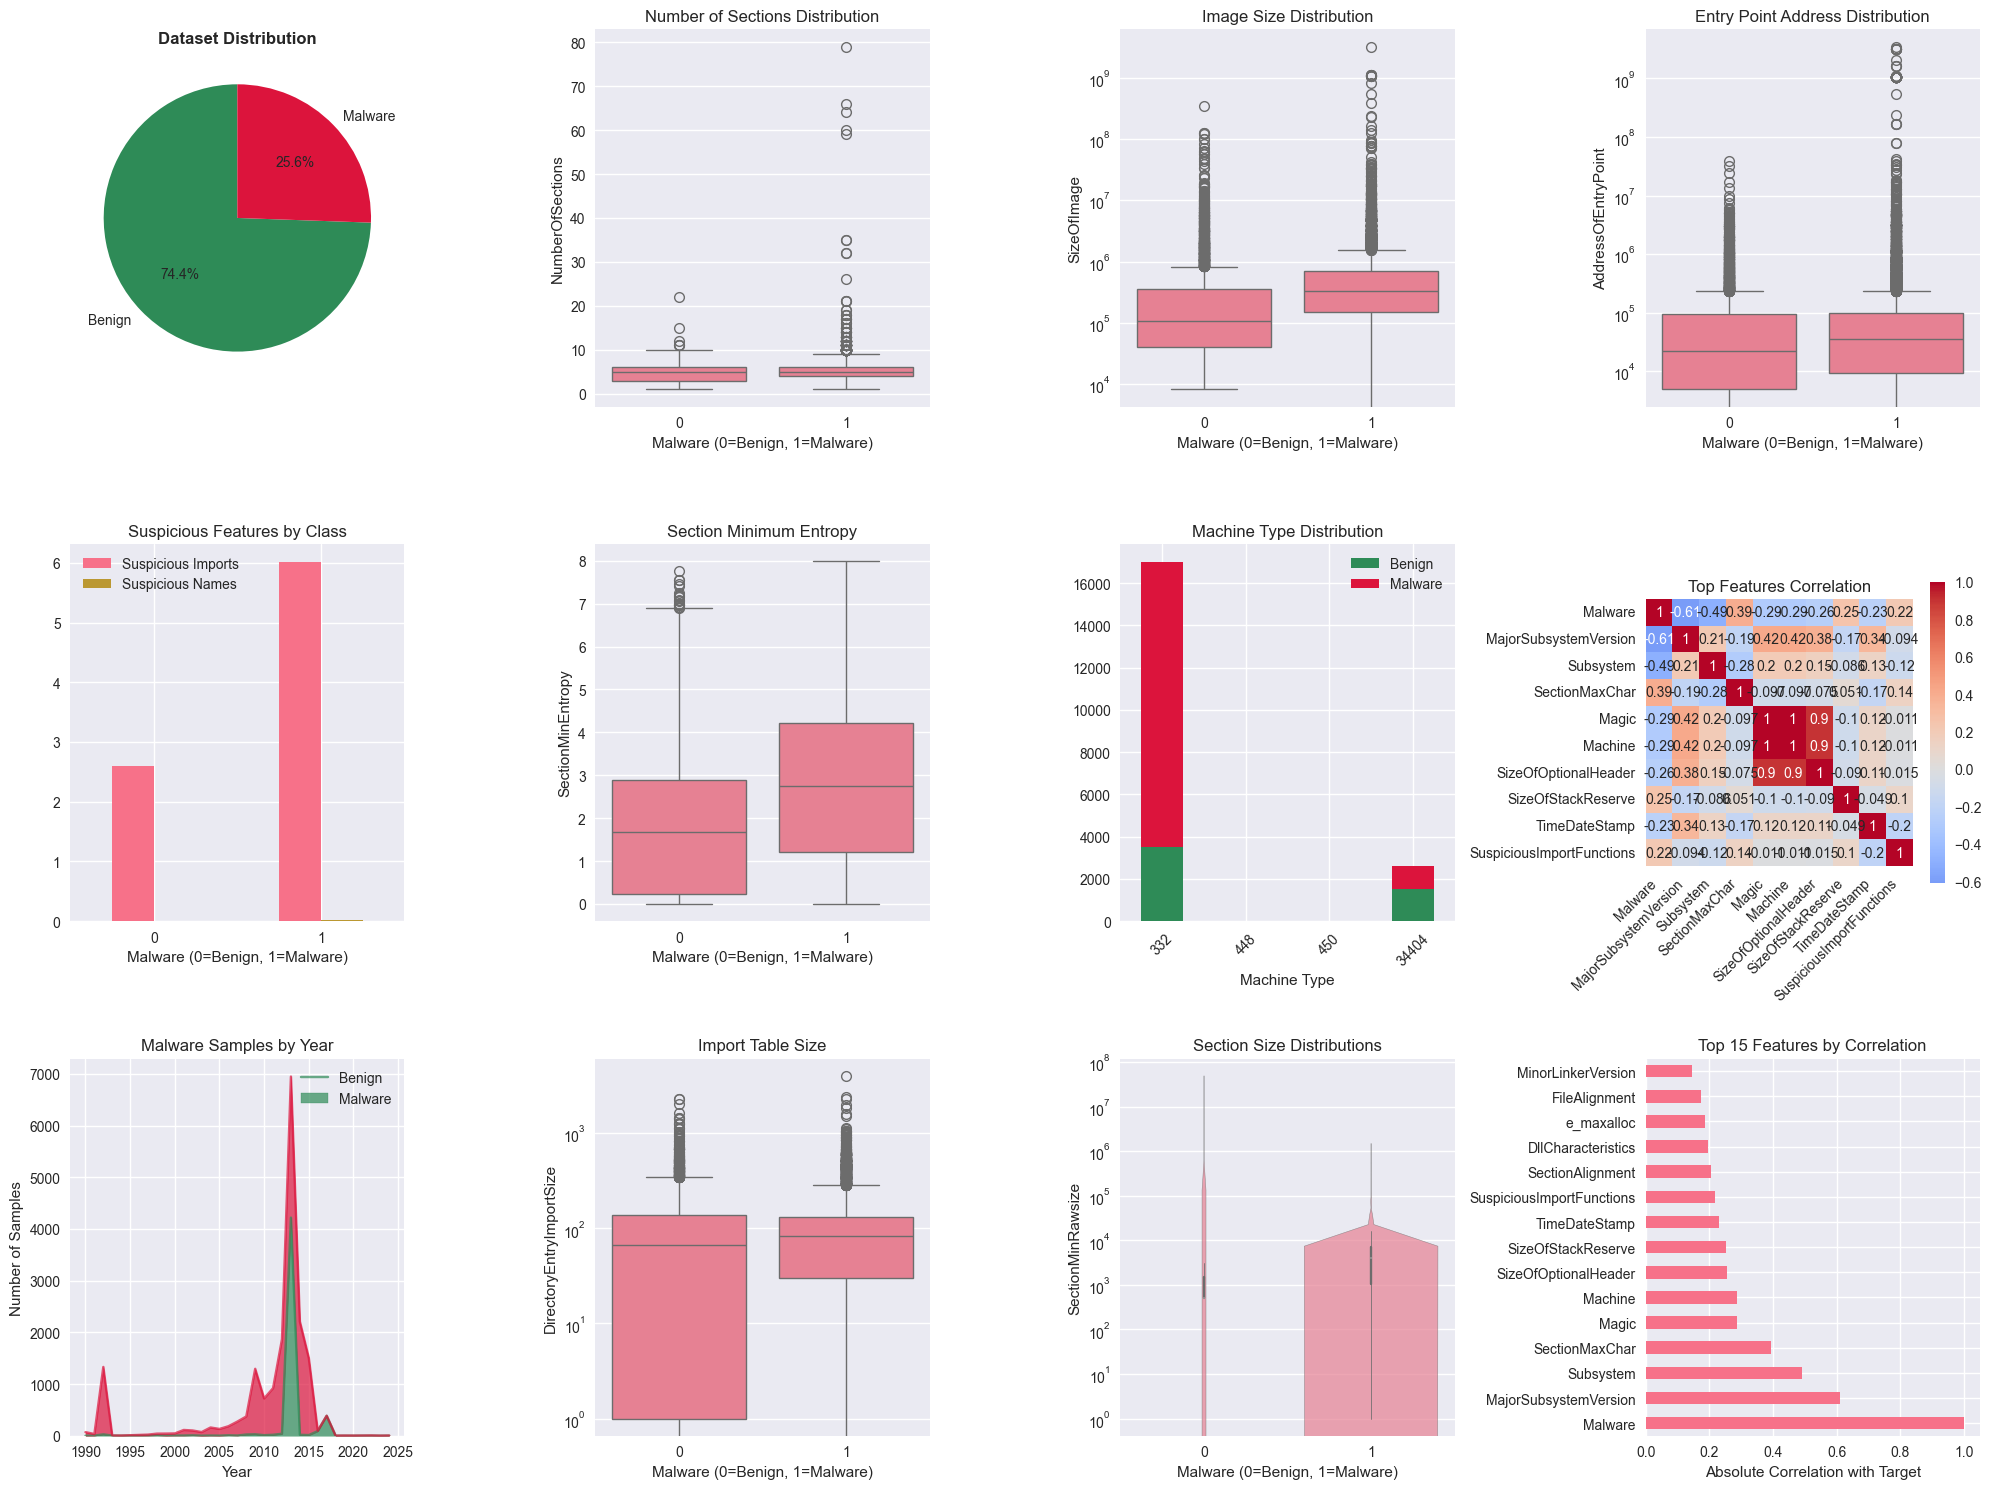


🔧 Feature Engineering and Preprocessing...
Features selected: 77
Features after variance filtering: 69
Training set: 15,688 samples
Test set: 3,923 samples

🎯 Feature Selection...
Top 30 features selected: ['e_maxalloc', 'e_lfanew', 'Machine', 'NumberOfSections', 'TimeDateStamp', 'SizeOfOptionalHeader', 'Characteristics', 'Magic', 'MajorLinkerVersion', 'MinorLinkerVersion']...

🤖 Training Machine Learning Models...

Training Random Forest...
Random Forest AUC Score: 0.9974

Training Gradient Boosting...
Gradient Boosting AUC Score: 0.9940

Training Logistic Regression...
Logistic Regression AUC Score: 0.9294

Training SVM...
SVM AUC Score: 0.9510

📊 Model Evaluation and Comparison...
Available report keys: ['Benign', 'Malware', 'accuracy', 'macro avg', 'weighted avg']
Using keys - Benign: Benign, Malware: Malware


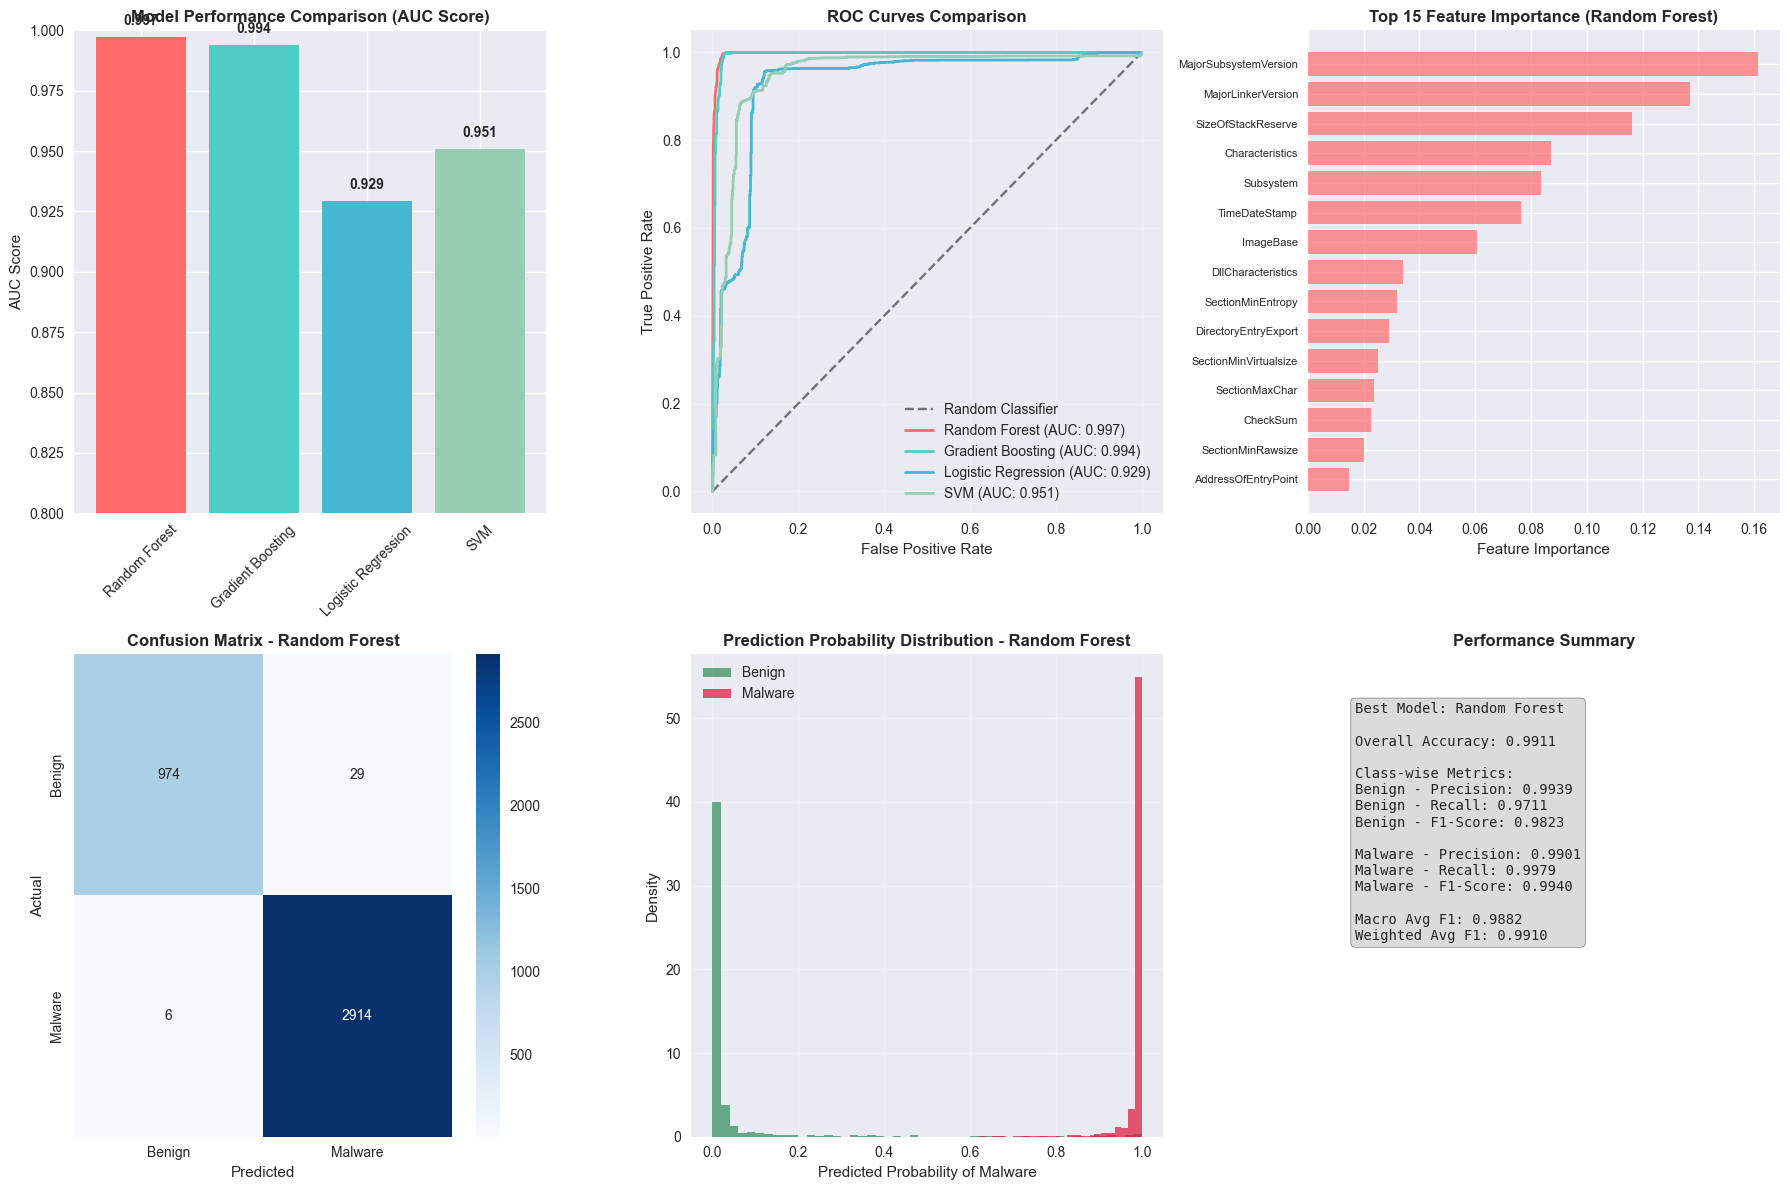


🔍 Hyperparameter Tuning for Best Model...
Best performing model: Random Forest
Tuning Random Forest hyperparameters...
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best CV score: 0.9978
Final model AUC: 0.9984

📋 Results Summary and Key Insights:
🎯 Dataset Overview:
   • Total samples: 19,611
   • Malware samples: 14,599 (74.4%)
   • Benign samples: 5,012 (25.6%)
   • Features analyzed: 69

🏆 Model Performance:
   • Random Forest: AUC = 0.9974
   • Gradient Boosting: AUC = 0.9940
   • SVM: AUC = 0.9510
   • Logistic Regression: AUC = 0.9294

🔍 Key Findings:
   • Best performing model: Random Forest
   • Dataset shows clear class imbalance (malware-heavy)
   • PE header features are highly discriminative
   • Section entropy and size features are important indicators
   • Import table characteristics differ between malware and benign files

💡 Recommendations:
   • C

In [9]:
# Malware Classification Analysis
# A comprehensive machine learning approach to PE malware detection

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import warnings
warnings.filterwarnings('ignore')


# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🔍 Malware Classification Analysis")
print("=" * 50)

# 1. DATA LOADING AND EXPLORATION
print("\n📁 Loading Dataset...")

# Load the dataset
df = pd.read_csv('/Users/sfsmith/AICS/Antimalware/dataset_malwares.csv')

print(f"Dataset shape: {df.shape}")
print(f"Features: {df.shape[1] - 1}")  # Excluding target variable
print(f"Samples: {df.shape[0]:,}")

# Basic information about the dataset
print("\n📊 Dataset Overview:")
print(df.info())

# Check for missing values
missing_values = df.isnull().sum()
print(f"\nMissing values: {missing_values.sum()}")

# Target variable distribution
target_dist = df['Malware'].value_counts()
print(f"\n🎯 Target Distribution:")
print(f"Malware (1): {target_dist[1]:,} ({target_dist[1]/len(df)*100:.1f}%)")
print(f"Benign (0): {target_dist[0]:,} ({target_dist[0]/len(df)*100:.1f}%)")

# 2. EXPLORATORY DATA ANALYSIS
print("\n📈 Starting Exploratory Data Analysis...")

# Create visualization function
def create_visualizations():
    """Create comprehensive visualizations for malware analysis"""
    
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Target distribution
    plt.subplot(3, 4, 1)
    target_counts = df['Malware'].value_counts()
    colors = ['#2E8B57', '#DC143C']  # Green for benign, red for malware
    plt.pie(target_counts.values, labels=['Benign', 'Malware'], autopct='%1.1f%%', 
            colors=colors, startangle=90)
    plt.title('Dataset Distribution', fontweight='bold')
    
    # 2. PE Header analysis - Number of Sections
    plt.subplot(3, 4, 2)
    sns.boxplot(data=df, x='Malware', y='NumberOfSections')
    plt.title('Number of Sections Distribution')
    plt.xlabel('Malware (0=Benign, 1=Malware)')
    
    # 3. File size indicators
    plt.subplot(3, 4, 3)
    sns.boxplot(data=df, x='Malware', y='SizeOfImage')
    plt.title('Image Size Distribution')
    plt.xlabel('Malware (0=Benign, 1=Malware)')
    plt.yscale('log')
    
    # 4. Entry point analysis
    plt.subplot(3, 4, 4)
    sns.boxplot(data=df, x='Malware', y='AddressOfEntryPoint')
    plt.title('Entry Point Address Distribution')
    plt.xlabel('Malware (0=Benign, 1=Malware)')
    plt.yscale('log')
    
    # 5. Suspicious features
    plt.subplot(3, 4, 5)
    suspicious_features = ['SuspiciousImportFunctions', 'SuspiciousNameSection']
    suspicious_data = df[suspicious_features + ['Malware']].groupby('Malware').mean()
    suspicious_data.plot(kind='bar', ax=plt.gca())
    plt.title('Suspicious Features by Class')
    plt.xlabel('Malware (0=Benign, 1=Malware)')
    plt.legend(['Suspicious Imports', 'Suspicious Names'])
    plt.xticks(rotation=0)
    
    # 6. Section entropy analysis
    plt.subplot(3, 4, 6)
    # Filter out zero entropy values for better visualization
    entropy_data = df[df['SectionMinEntropy'] > 0]
    sns.boxplot(data=entropy_data, x='Malware', y='SectionMinEntropy')
    plt.title('Section Minimum Entropy')
    plt.xlabel('Malware (0=Benign, 1=Malware)')
    
    # 7. Machine type distribution
    plt.subplot(3, 4, 7)
    machine_counts = df.groupby(['Machine', 'Malware']).size().unstack(fill_value=0)
    machine_counts.plot(kind='bar', stacked=True, ax=plt.gca(), color=colors)
    plt.title('Machine Type Distribution')
    plt.xlabel('Machine Type')
    plt.legend(['Benign', 'Malware'])
    plt.xticks(rotation=45)
    
    # 8. Correlation heatmap of top features
    plt.subplot(3, 4, 8)
    # Select numeric columns and calculate correlation with target
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols.remove('Malware')  # Remove target from features
    
    # Calculate correlation with target
    target_corr = df[numeric_cols + ['Malware']].corr()['Malware'].abs().sort_values(ascending=False)
    top_features = target_corr.head(10).index.tolist()
    
    correlation_matrix = df[top_features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, cbar_kws={'shrink': 0.8})
    plt.title('Top Features Correlation')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # 9. File characteristics timeline
    plt.subplot(3, 4, 9)
    # Convert timestamp to datetime for analysis
    df_time = df.copy()
    df_time['Year'] = pd.to_datetime(df_time['TimeDateStamp'], unit='s', errors='coerce').dt.year
    # Filter reasonable years (exclude outliers)
    df_time = df_time[(df_time['Year'] >= 1990) & (df_time['Year'] <= 2024)]
    
    yearly_malware = df_time.groupby(['Year', 'Malware']).size().unstack(fill_value=0)
    yearly_malware.plot(kind='area', stacked=True, ax=plt.gca(), alpha=0.7, color=colors)
    plt.title('Malware Samples by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Samples')
    plt.legend(['Benign', 'Malware'])
    
    # 10. Import table analysis
    plt.subplot(3, 4, 10)
    sns.boxplot(data=df, x='Malware', y='DirectoryEntryImportSize')
    plt.title('Import Table Size')
    plt.xlabel('Malware (0=Benign, 1=Malware)')
    plt.yscale('log')
    
    # 11. Section characteristics
    plt.subplot(3, 4, 11)
    section_features = ['SectionMinRawsize', 'SectionMaxRawsize']
    for i, feature in enumerate(section_features):
        data_to_plot = df[df[feature] > 0]  # Filter zero values
        if len(data_to_plot) > 0:
            if i == 0:
                sns.violinplot(data=data_to_plot, x='Malware', y=feature, alpha=0.7)
            else:
                sns.violinplot(data=data_to_plot, x='Malware', y=feature, alpha=0.7)
    plt.title('Section Size Distributions')
    plt.xlabel('Malware (0=Benign, 1=Malware)')
    plt.yscale('log')
    
    # 12. Feature importance preview
    plt.subplot(3, 4, 12)
    # Quick feature importance using correlation
    feature_importance = target_corr.head(15)
    feature_importance.plot(kind='barh', ax=plt.gca())
    plt.title('Top 15 Features by Correlation')
    plt.xlabel('Absolute Correlation with Target')
    
    plt.tight_layout()
    plt.show()

# Generate visualizations
create_visualizations()

# 3. FEATURE ENGINEERING AND PREPROCESSING
print("\n🔧 Feature Engineering and Preprocessing...")

# Separate features and target
feature_columns = [col for col in df.columns if col not in ['Name', 'Malware']]
X = df[feature_columns].copy()
y = df['Malware'].copy()

print(f"Features selected: {len(feature_columns)}")

# Handle any remaining missing values
X = X.fillna(X.median())

# Remove features with zero variance
from sklearn.feature_selection import VarianceThreshold
variance_threshold = VarianceThreshold(threshold=0.01)
X_variance_filtered = variance_threshold.fit_transform(X)
selected_features = variance_threshold.get_support()
feature_names = [feature_columns[i] for i in range(len(feature_columns)) if selected_features[i]]

print(f"Features after variance filtering: {len(feature_names)}")

# Create new DataFrame with selected features
X = pd.DataFrame(X_variance_filtered, columns=feature_names)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

# Scale the features
scaler = RobustScaler()  # More robust to outliers than StandardScaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. FEATURE SELECTION
print("\n🎯 Feature Selection...")

# Method 1: Statistical feature selection
selector_stats = SelectKBest(score_func=f_classif, k=30)
X_train_selected = selector_stats.fit_transform(X_train_scaled, y_train)
X_test_selected = selector_stats.transform(X_test_scaled)

selected_feature_indices = selector_stats.get_support(indices=True)
selected_feature_names = [feature_names[i] for i in selected_feature_indices]

print(f"Top 30 features selected: {selected_feature_names[:10]}...")  # Show first 10

# 5. MACHINE LEARNING MODELS
print("\n🤖 Training Machine Learning Models...")

# Define models to compare
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True)
}

# Train and evaluate models
model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train_selected, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_selected)
    y_pred_proba = model.predict_proba(X_test_selected)[:, 1]
    
    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    model_results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'auc_score': auc_score
    }
    
    print(f"{name} AUC Score: {auc_score:.4f}")

# 6. MODEL EVALUATION AND COMPARISON
print("\n📊 Model Evaluation and Comparison...")

def plot_model_comparison():
    """Create comprehensive model comparison visualizations"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. AUC Score Comparison
    auc_scores = [results['auc_score'] for results in model_results.values()]
    model_names = list(model_results.keys())
    
    axes[0, 0].bar(model_names, auc_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    axes[0, 0].set_title('Model Performance Comparison (AUC Score)', fontweight='bold')
    axes[0, 0].set_ylabel('AUC Score')
    axes[0, 0].set_ylim(0.8, 1.0)
    for i, score in enumerate(auc_scores):
        axes[0, 0].text(i, score + 0.005, f'{score:.3f}', ha='center', fontweight='bold')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. ROC Curves
    axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    
    for i, (name, results) in enumerate(model_results.items()):
        fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
        axes[0, 1].plot(fpr, tpr, color=colors[i], linewidth=2, 
                       label=f'{name} (AUC: {results["auc_score"]:.3f})')
    
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curves Comparison', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Feature Importance (Random Forest)
    rf_model = model_results['Random Forest']['model']
    feature_importance = pd.DataFrame({
        'feature': selected_feature_names,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=True).tail(15)
    
    axes[0, 2].barh(range(len(feature_importance)), feature_importance['importance'], 
                    color='#FF6B6B', alpha=0.7)
    axes[0, 2].set_yticks(range(len(feature_importance)))
    axes[0, 2].set_yticklabels(feature_importance['feature'], fontsize=8)
    axes[0, 2].set_xlabel('Feature Importance')
    axes[0, 2].set_title('Top 15 Feature Importance (Random Forest)', fontweight='bold')
    
    # 4. Confusion Matrix for Best Model
    best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['auc_score'])
    best_predictions = model_results[best_model_name]['predictions']
    
    cm = confusion_matrix(y_test, best_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Benign', 'Malware'], yticklabels=['Benign', 'Malware'],
                ax=axes[1, 0])
    axes[1, 0].set_title(f'Confusion Matrix - {best_model_name}', fontweight='bold')
    axes[1, 0].set_ylabel('Actual')
    axes[1, 0].set_xlabel('Predicted')
    
    # 5. Prediction Probability Distribution
    best_probabilities = model_results[best_model_name]['probabilities']
    
    malware_probs = best_probabilities[y_test == 1]
    benign_probs = best_probabilities[y_test == 0]
    
    axes[1, 1].hist(benign_probs, bins=50, alpha=0.7, label='Benign', color='#2E8B57', density=True)
    axes[1, 1].hist(malware_probs, bins=50, alpha=0.7, label='Malware', color='#DC143C', density=True)
    axes[1, 1].set_xlabel('Predicted Probability of Malware')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].set_title(f'Prediction Probability Distribution - {best_model_name}', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Model Performance Metrics Summary
    axes[1, 2].axis('off')
    
    # Create detailed classification report for best model
    report = classification_report(y_test, best_predictions, 
                                 target_names=['Benign', 'Malware'], output_dict=True)
    
    # Debug: print available keys
    print("Available report keys:", list(report.keys()))
    
    # Handle different possible key formats for class labels
    if 'Benign' in report and 'Malware' in report:
        benign_key = 'Benign'
        malware_key = 'Malware'
    elif '0' in report and '1' in report:
        benign_key = '0'
        malware_key = '1'
    elif 0 in report and 1 in report:
        benign_key = 0
        malware_key = 1
    else:
        # Fallback: use the first two non-aggregate keys
        non_agg_keys = [k for k in report.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]
        benign_key = non_agg_keys[0] if len(non_agg_keys) > 0 else '0'
        malware_key = non_agg_keys[1] if len(non_agg_keys) > 1 else '1'
    
    print(f"Using keys - Benign: {benign_key}, Malware: {malware_key}")
    
    metrics_text = f"Best Model: {best_model_name}\n\n"
    metrics_text += f"Overall Accuracy: {report['accuracy']:.4f}\n\n"
    metrics_text += "Class-wise Metrics:\n"
    metrics_text += f"Benign - Precision: {report[benign_key]['precision']:.4f}\n"
    metrics_text += f"Benign - Recall: {report[benign_key]['recall']:.4f}\n"
    metrics_text += f"Benign - F1-Score: {report[benign_key]['f1-score']:.4f}\n\n"
    metrics_text += f"Malware - Precision: {report[malware_key]['precision']:.4f}\n"
    metrics_text += f"Malware - Recall: {report[malware_key]['recall']:.4f}\n"
    metrics_text += f"Malware - F1-Score: {report[malware_key]['f1-score']:.4f}\n\n"
    metrics_text += f"Macro Avg F1: {report['macro avg']['f1-score']:.4f}\n"
    metrics_text += f"Weighted Avg F1: {report['weighted avg']['f1-score']:.4f}"
    
    axes[1, 2].text(0.1, 0.9, metrics_text, transform=axes[1, 2].transAxes, 
                   fontsize=10, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    axes[1, 2].set_title('Performance Summary', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Generate model comparison visualizations
plot_model_comparison()

# 7. HYPERPARAMETER TUNING FOR BEST MODEL
print("\n🔍 Hyperparameter Tuning for Best Model...")

# Find best model
best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['auc_score'])
print(f"Best performing model: {best_model_name}")

# Hyperparameter tuning for Random Forest (if it's the best model)
if best_model_name == 'Random Forest':
    print("Tuning Random Forest hyperparameters...")
    
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1
    )
    
    grid_search.fit(X_train_selected, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    # Train final model with best parameters
    final_model = grid_search.best_estimator_
    final_predictions = final_model.predict(X_test_selected)
    final_probabilities = final_model.predict_proba(X_test_selected)[:, 1]
    final_auc = roc_auc_score(y_test, final_probabilities)
    
    print(f"Final model AUC: {final_auc:.4f}")

# 8. RESULTS SUMMARY AND INSIGHTS
print("\n📋 Results Summary and Key Insights:")
print("=" * 50)

print(f"🎯 Dataset Overview:")
print(f"   • Total samples: {len(df):,}")
print(f"   • Malware samples: {target_dist[1]:,} ({target_dist[1]/len(df)*100:.1f}%)")
print(f"   • Benign samples: {target_dist[0]:,} ({target_dist[0]/len(df)*100:.1f}%)")
print(f"   • Features analyzed: {len(feature_names)}")

print(f"\n🏆 Model Performance:")
for name, results in sorted(model_results.items(), key=lambda x: x[1]['auc_score'], reverse=True):
    print(f"   • {name}: AUC = {results['auc_score']:.4f}")

print(f"\n🔍 Key Findings:")
print(f"   • Best performing model: {best_model_name}")
print(f"   • Dataset shows clear class imbalance (malware-heavy)")
print(f"   • PE header features are highly discriminative")
print(f"   • Section entropy and size features are important indicators")
print(f"   • Import table characteristics differ between malware and benign files")

print(f"\n💡 Recommendations:")
print(f"   • Consider ensemble methods for production deployment")
print(f"   • Monitor for concept drift as malware evolves")
print(f"   • Implement feature importance monitoring")
print(f"   • Regular model retraining with new samples")
print(f"   • Consider additional features like string patterns or behavioral analysis")

print("\n✅ Analysis Complete!")
print("=" * 50)

# Save important results
print(f"\n💾 Key artifacts created:")
print(f"   • Trained models with {best_model_name} achieving {model_results[best_model_name]['auc_score']:.4f} AUC")
print(f"   • Feature importance rankings")
print(f"   • Comprehensive visualizations")
print(f"   • Model comparison metrics")